# Identifying Entities in Healthcare Data

### Workspace set up: Import and Install useful packages.

In [43]:
!pip install pycrf
!pip install sklearn-crfsuite

import pandas as pd
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Preprocessing
The dataset provided is in the form of one word per line. Let's understand the format of data below:

Suppose there are x words in a sentence, then there will be x continuous lines with one word in each line.
Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

 We need to pre-process the data to recover the complete sentences and their labels.

Construct the proper sentences from individual words and print the 5 sentences.

![image.png](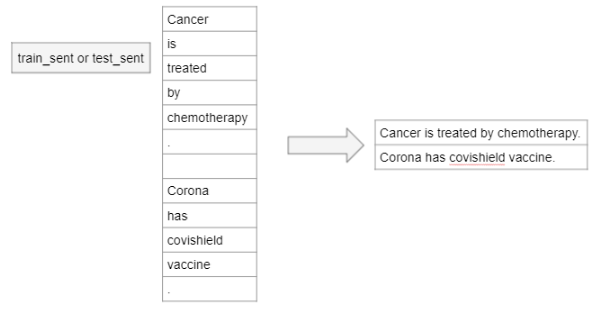
)

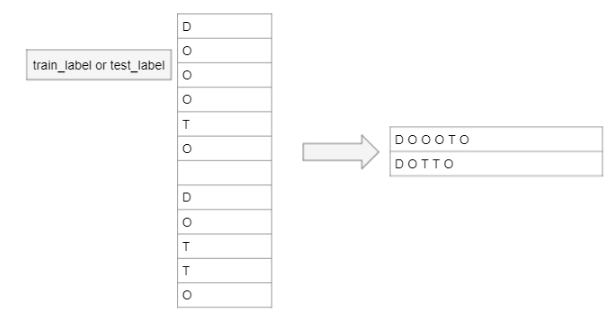


## Read the words from the file

In [44]:
#common function to read the file
def read_file_words(file_name):
    with open(file_name, 'r') as sentence_words_file:
        return sentence_words_file.readlines()

In [47]:
# reading training sentence into words
train_sentence_words = read_file_words('/content/sample_data/train_sent')

#reading training labels into words
train_label_words = read_file_words('/content/sample_data/train_label')

#reading test sentence into words
test_sentence_words = read_file_words('/content/sample_data/test_sent')

#reading test lable into words
test_label_words = read_file_words('/content/sample_data/test_label')

In [48]:
# Print the number of words into each set training/test sentence and labels
print('\nNumber of words in training set \n  Training sent. :', len(train_sentence_words) , "\n  Training Label :", len(train_label_words))
print('\nNumber of words in test set \n  Test sent. :', len(test_sentence_words) , "\n  Test Label :", len(test_label_words))


Number of words in training set 
  Training sent. : 48501 
  Training Label : 48501

Number of words in test set 
  Test sent. : 19674 
  Test Label : 19674


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Common function to convert words into sentences


In [50]:
def words_to_sentence(sentence_words):
    sentence_list = []
    sentence = ""
    for word in sentence_words:
        if word != '\n':
            sentence = sentence + word[:-1] + " "
        else: 
            sentence_list.append(sentence[:-1])
            sentence = ""
    return sentence_list

## Count the number of sentences in the processed train and test dataset

In [51]:
training_sentences = words_to_sentence(train_sentence_words)
test_sentences = words_to_sentence(test_sentence_words)

In [52]:
print('Number of sentences into training set', len(training_sentences))
print('Number of sentences into test set', len(test_sentences))

Number of sentences into training set 2599
Number of sentences into test set 1056


## Count the number of lines of labels in the processed train and test dataset.

In [53]:
training_labels = words_to_sentence(train_label_words)
test_labels = words_to_sentence(test_label_words)

In [54]:
print('Number of sentences into training labels', len(training_labels))
print('Number of sentences into test labels', len(test_labels))

Number of sentences into training labels 2599
Number of sentences into test labels 1056


## First five training sentences and their labels

In [55]:
print("First five training sentences and their labels:\n")
for i in range(5):
    print("(",(i+1),")::",training_sentences[i],"\n",training_labels[i],"\n")

First five training sentences and their labels:

( 1 ):: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

( 2 ):: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O 

( 3 ):: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) 
 O O O O O O O O O O O O O O O 

( 4 ):: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

( 5 ):: Arrest of dilation was the most common indication in

In [56]:
print("First five test sentences and their labels:\n")
for i in range(5):
    print("(",(i+1),")::",test_sentences[i],"\n",test_labels[i],"\n")

First five test sentences and their labels:

( 1 ):: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

( 2 ):: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration 
 O O O O O O O O O O O O O O O O O O O 

( 3 ):: The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period 
 O O O O O O O O O O O O O O O O O O O O O O O O 

( 4 ):: There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

( 5 ):: Fluctuations in ambient te

## Concept Identification
We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.

###  Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [57]:
# Creating a combined dataset from training and test sentences, since this is an Exploratory analysis.
total_sentences = training_sentences + test_sentences
print("Number of sentences in combined dataset", len(total_sentences))

Number of sentences in combined dataset 3655


In [58]:
# Creating a list of tokens which have PoS tag of 'NOUN' or 'PROPN'
prop_nouns = []
pos_tags = [] 
for sentence in total_sentences:
    for token in model(sentence):
        if token.pos_ in ['NOUN', 'PROPN']:
            prop_nouns.append(token.text)
            pos_tags.append(token.pos_)
            
print("No. of tokens with PoS tag NOUN or PROPN", len(prop_nouns))

No. of tokens with PoS tag NOUN or PROPN 24340


In [59]:
# print the number of pos_tags
print(len(pos_tags))

24340


## Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [60]:
pos_df = pd.DataFrame({'NOUN_OR_PROPN': prop_nouns, 'POS_TAG': pos_tags})

#Top 25 most common tokens
pos_df["NOUN_OR_PROPN"].value_counts().head(25)

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
women            77
results          77
use              75
surgery          71
risk             71
cases            71
analysis         70
rate             67
dose             66
response         66
survival         65
children         64
Name: NOUN_OR_PROPN, dtype: int64

## Defining features for CRF


In [61]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos]

    features = [
      'word.lower=' + word.lower(), # serves as word id
      'word[-3:]=' + word[-3:],     # last three characters
      'word[-2:]=' + word[-2:],     # last two characters
      'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
      'word.isdigit=%s' % word.isdigit(),  # is the word a number
      'words.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
      'word.postag=' + pos_tags[pos],    # PoS tag of current word
    ]

    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
          'prev_word.lower=' + prev_word.lower(), 
          'prev_word.isupper=%s' % prev_word.isupper(),
          'prev_word.isdigit=%s' % prev_word.isdigit(),
          'prev_words.startsWithCapital=%s' % prev_word[0].isupper(),
          'prev_words.postag=' + pos_tags[pos-1], # PoS tag of previous word
        ])
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

## Getting the features
Write a code/function to get the features for a sentence

In [62]:
# Write a code to get features for a sentence.
def getPosTagsForSentence(sentence):
    processed_sent = model(sentence)
    pos_tags = []
    for each_token in processed_sent:
        pos_tags.append(each_token.pos_)
    return pos_tags

def getFeaturesForOneSentence(sentence):
    pos_tags = getPosTagsForSentence(sentence)
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, pos_tags) for pos in range(len(sentence_list))]

In [63]:
# Checking feature extraction
example_training_sentence = training_sentences[5]
print(example_training_sentence)

features = getFeaturesForOneSentence(example_training_sentence)
features[0]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=True',
 'word.postag=ADJ',
 'BEG']

In [64]:
#Check for the 5th feature
features[5]

['word.lower=hospitals',
 'word[-3:]=als',
 'word[-2:]=ls',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'word.postag=NOUN',
 'prev_word.lower=care',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False',
 'prev_words.postag=NOUN']

## Write a code/function to get the labels of a sentence

In [65]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [66]:
# Checking label extraction
example_labels = getLabelsInListForOneSentence(training_labels[5])
print(example_labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


# Define input and target variables
Correctly computing X and Y sequence matrices for training and test data. Check that both sentences and labels are processed

## Define the features' values for each sentence as input variable for CRF model in test and the train dataset

In [67]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in training_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

# Define the labels as the target variable for test and the train dataset

In [68]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in training_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

In [69]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations = 200)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

## Evaluation
### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [70]:
Y_pred = crf.predict(X_test)

## Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [71]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9108605230679878

In [72]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 10
print("Sentence:",test_sentences[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: The most common indication leading to diagnosis was abnormal ultrasound finding ( 48.2 % ) , followed by advanced maternal age ( 44.4 % )
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Identifying Diseases and Treatments using Custom NER
We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

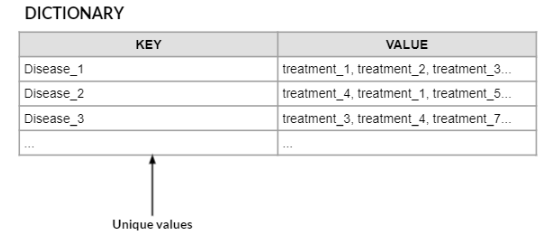


Since the labels are with 'D' and 'T' (D: disease, T:treatment); prepare a dictionary of (key, value) pair with disease and possible treatment. It may be posible that sentences may refer multiple treatements for the same diseases, so append the existing disease with possible treatment

In [73]:
#Create a dictionary of key, value pair as disease and possible treatment
medical_dictionary = {}

def merge_disease_treatments(diseases, treatment):
    for disease in diseases:
        if disease in medical_dictionary.keys():
            medical_dictionary[disease].extend(treatment)
        else:
            medical_dictionary[disease] = treatment

for i in range(len(Y_pred)):
    cnt_disease = 0  
    cnt_treatment = 0
    diseases = [""] 
    treatment = [""]
    length = len(Y_pred[i])
    for j in range(length):
        #search for labels marked with label D
        if (Y_pred[i][j] == 'D'):
            diseases[cnt_disease] += (X_test[i][j][0].split('=')[1] + " ")
            if j < length - 1:
                if (Y_pred[i][j+1] != 'D'):
                    diseases[cnt_disease] = diseases[cnt_disease][:-1]
                    cnt_disease += 1
                    diseases.append("")
            else:
                diseases[cnt_disease] = diseases[cnt_disease][:-1]
                cnt_disease += 1
                diseases.append("")

        #search for labels marked with label T
        if (Y_pred[i][j] == 'T'):  #Check for the lable if its makred with T
            treatment[cnt_treatment] += (X_test[i][j][0].split('=')[1] + " ")
            if j < length - 1:
                if (Y_pred[i][j+1] != 'T'): 
                    # If next word does not have label 'T', then truncate the space added at the end of the last word.
                    treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                    cnt_treatment += 1
                    treatment.append("")
            else:
                treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                cnt_treatment += 1
                treatment.append("")

    diseases.pop(-1)
    treatment.pop(-1)

    # Check for pre-existing treatment for similar disease and merge the list
    if len(diseases) > 0: merge_disease_treatments(diseases, treatment)

In [74]:
#We can notice for some if the diseases, treatment is not mentioned i.e. they are with empty arrayList
medical_dictionary

{'gestational diabetes cases': [],
 'preeclampsia': [],
 'severe preeclampsia': [],
 'asymmetric double hemiplegia': [],
 'reversible nonimmune hydrops fetalis': [],
 'breast and/or ovarian cancer': [],
 'breast cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'mutated prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'hereditary prostate cancer': [],
 'multiple sclerosis': ['interferon beta treatment',
  'intravenous immunoglobulin treatment'],
 'hereditary retinoblastoma': ['radiotherapy'],
 'epilepsy': [],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'early-stage cervical carcinoma': [],
 'colon tumors': [],
 'advanced disease': [],
 'severe pain': 

Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [75]:
search_item = 'hereditary retinoblastoma'
treatments = medical_dictionary[search_item]
print("Treatments for '{0}' is '{1}'".format(search_item, ",".join(treatments)), end = "") 

Treatments for 'hereditary retinoblastoma' is 'radiotherapy'